In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import minimize  # <-- non-DL optimizer
from dataset_HR import AdSBHDataset
from model_HR_new import AdSBHNet
from constants import dreal, dcomplex


# Import dataset

Using 14 data points with TL < 1


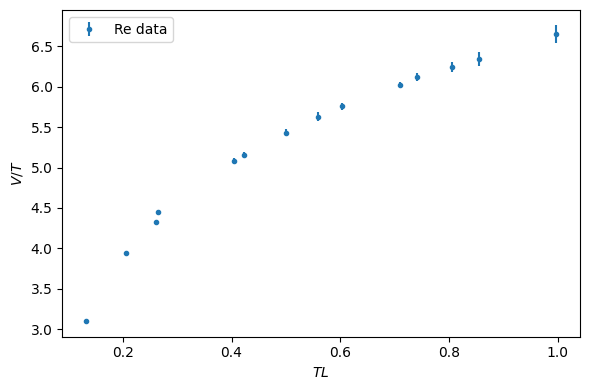

In [2]:
dataset = AdSBHDataset(file="1607latticeT290.txt")  # or T113 etc.

# focus on TL < 1 like before (optional)
mask_L = dataset.L < 1.0

L_all     = dataset.L[mask_L].clone()        # torch tensors (CPU)
V_all     = dataset.V[mask_L].clone()
sigma_all = dataset.sigma[mask_L].clone()

print(f"Using {len(L_all)} data points with TL < 1")

plt.figure(figsize=(6,4))
plt.errorbar(L_all.numpy(), V_all.real.numpy(),
             yerr=sigma_all.real.numpy(),
             fmt='.', label='Re data')
plt.xlabel(r'$T L$'); plt.ylabel(r'$V/T$'); plt.legend(); plt.tight_layout()

# ----------------- model -----------------
model = AdSBHNet(N=4, std=0.5)

# start at pure AdS–BH: a=b=0, coef=1, shift=0
with torch.no_grad():
    model.a.zero_()
    model.b.zero_()
    model.logcoef.zero_()
    model.shift.zero_()

model.eval()

dev = model.a.device
dt  = model.a.dtype

# Helper functions

In [3]:
@torch.no_grad()
def connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500):
    """
    Real connected branch:
      - scan real z_*
      - compute L(z_*), V(z_*)
      - sort by L
      - truncate at global maximum of L (turning point)
    """
    zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real

    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]

    imax = torch.argmax(Lc)
    return Lc[:imax+1], Vc[:imax+1]


@torch.no_grad()
def interp_1d(x, y, xq, eps=1e-12):
    """
    Vectorized linear interpolation + linear extrapolation.
    x, y real 1D tensors; xq anything broadcastable.
    """
    dt_, dev_ = x.dtype, x.device
    xq = torch.as_tensor(xq, dtype=dt_, device=dev_).reshape(-1)

    pos = torch.searchsorted(x, xq, right=True)
    i0 = (pos - 1).clamp(0, x.numel() - 2)
    i1 = i0 + 1
    x0, x1 = x[i0], x[i1]
    y0, y1 = y[i0], y[i1]

    w     = (xq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w * (y1 - y0)

    mL = (y[1] - y[0])   / (x[1] - x[0]   + eps)
    mR = (y[-1] - y[-2]) / (x[-1] - x[-2] + eps)

    v_left  = y[0]  + mL * (xq - x[0])
    v_right = y[-1] + mR * (xq - x[-1])

    v = torch.where(xq <  x[0],  v_left,  v_lin)
    v = torch.where(xq >  x[-1], v_right, v)
    return v


@torch.no_grad()
def get_theta(model):
    a_np = model.a.detach().cpu().numpy().astype(np.float64)
    b_np = model.b.detach().cpu().numpy().astype(np.float64)
    logc = float(model.logcoef.detach().cpu().item())
    sh   = float(model.shift.detach().cpu().item())
    return np.concatenate([a_np, b_np, np.array([logc, sh], dtype=np.float64)])


@torch.no_grad()
def set_theta(model, theta):
    theta = np.asarray(theta, dtype=np.float64)
    Na = model.a.numel()
    Nb = model.b.numel()
    assert theta.size == Na + Nb + 2

    a_np  = theta[0:Na]
    b_np  = theta[Na:Na+Nb]
    logc  = theta[-2]
    shift = theta[-1]

    model.a.copy_(torch.tensor(a_np, dtype=dt, device=dev))
    model.b.copy_(torch.tensor(b_np, dtype=dt, device=dev))
    model.logcoef.copy_(torch.tensor(logc, dtype=dt, device=dev))
    model.shift.copy_(torch.tensor(shift, dtype=dt, device=dev))


In [4]:
@torch.no_grad()
def connected_branch(model, zmin=0.02, zmax=0.9995, Nc=2500):
    """
    Real connected branch:
      - scan real z_*
      - compute L(z_*), V(z_*)
      - sort by L
      - truncate at global maximum of L (turning point)
    """
    zs = torch.linspace(zmin, zmax, Nc, dtype=dt, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real

    idx = torch.argsort(Lc)
    Lc, Vc = Lc[idx], Vc[idx]

    imax = torch.argmax(Lc)
    return Lc[:imax+1], Vc[:imax+1]


@torch.no_grad()
def interp_1d(x, y, xq, eps=1e-12):
    """
    Vectorized linear interpolation + linear extrapolation.
    x, y real 1D tensors; xq anything broadcastable.
    """
    dt_, dev_ = x.dtype, x.device
    xq = torch.as_tensor(xq, dtype=dt_, device=dev_).reshape(-1)

    pos = torch.searchsorted(x, xq, right=True)
    i0 = (pos - 1).clamp(0, x.numel() - 2)
    i1 = i0 + 1
    x0, x1 = x[i0], x[i1]
    y0, y1 = y[i0], y[i1]

    w     = (xq - x0) / (x1 - x0 + eps)
    v_lin = y0 + w * (y1 - y0)

    mL = (y[1] - y[0])   / (x[1] - x[0]   + eps)
    mR = (y[-1] - y[-2]) / (x[-1] - x[-2] + eps)

    v_left  = y[0]  + mL * (xq - x[0])
    v_right = y[-1] + mR * (xq - x[-1])

    v = torch.where(xq <  x[0],  v_left,  v_lin)
    v = torch.where(xq >  x[-1], v_right, v)
    return v


# Initialization

In [5]:
with torch.no_grad():
    # baseline branch with a=b=0
    Lm, Vm_full = connected_branch(model)  # Vm_full real

    Ld = L_all.to(device=dev, dtype=dt)
    Vd = V_all.real.to(device=dev, dtype=dt)

    # only in-support points
    mask = (Ld >= Lm[0]) & (Ld <= Lm[-1])
    if mask.sum() < 3:
        print("Warning: too few in-support points for LS init.")
    L_fit = Ld[mask]
    Y_fit = Vd[mask]

    # model at those L using interpolation
    X_fit_full = interp_1d(Lm, Vm_full, L_fit)  # FULL V (with current scale), NO shift

    # remove current scale before LS (logcoef is 0 → exp=1, but keep structure)
    X_fit = X_fit_full / model.logcoef.exp()

    x_np = X_fit.cpu().numpy().reshape(-1, 1)
    y_np = Y_fit.cpu().numpy()

    fit = LinearRegression().fit(x_np, y_np)
    slope = max(float(fit.coef_[0]), 1e-12)
    shift = float(fit.intercept_)

    model.logcoef.copy_(torch.tensor(np.log(slope), dtype=dt, device=dev))
    model.shift.copy_(torch.tensor(shift,        dtype=dt, device=dev))

print(f"After LS init: coef = {model.logcoef.exp().item():.3f}, shift = {model.shift.item():.3f}")


After LS init: coef = 0.251, shift = 5.828


# Define parameter pack/unpack and the cost chi^2

Let's treat our parameters as 

$\theta = (a_0,\dots,a_{N-1}, \ b_0,\dots ,b_{N-1}, \ shift, \ logcoef)

$ \chi^2(\theta) = \langle \frac{(V_{model}(L_i,\theta)-V_i)^2}{\sigma_i^2}\rangle + \lambda_{phy} \mathcal{P}_{UV/horizon}$

so we don't have any epochs or dataloaders, just a scalar function.

In [6]:
@torch.no_grad()
def get_theta_ab(model):
    a_np = model.a.detach().cpu().numpy().astype(np.float64)
    b_np = model.b.detach().cpu().numpy().astype(np.float64)
    return np.concatenate([a_np, b_np])


@torch.no_grad()
def set_theta_ab(model, theta):
    theta = np.asarray(theta, dtype=np.float64)
    Na = model.a.numel()
    Nb = model.b.numel()
    assert theta.size == Na + Nb

    a_np = theta[0:Na]
    b_np = theta[Na:Na+Nb]

    model.a.copy_(torch.tensor(a_np, dtype=dt, device=dev))
    model.b.copy_(torch.tensor(b_np, dtype=dt, device=dev))


In [7]:
lam_L2 = 1e-4   # tiny regularization, just to avoid huge parameters
p_L    = 2.0    # exponent to emphasize large L

@torch.no_grad()
def chi2_real_branch_ab(theta):
    # 0) set current (a,b)
    set_theta_ab(model, theta)

    # 1) real connected branch with these (a,b), but using the *fixed* coef, shift
    Lm, Vm = connected_branch(model)  # Vm is unshifted real V(z*)

    if Lm.numel() < 5:
        # if geometry collapses, punish it
        return 1e10

    # 2) interpolate/extrapolate to all data L
    Ld = L_all.to(device=dev, dtype=dt)
    Vd = V_all.real.to(device=dev, dtype=dt)
    Sd = sigma_all.real.to(device=dev, dtype=dt).clamp_min(1e-8)

    V_model = interp_1d(Lm, Vm, Ld) + model.shift  # add fixed shift

    # 3) residuals and weights
    r = V_model - Vd
    w_stat = 1.0 / (Sd**2)
    wL = (Ld / Ld.max()).clamp_min(0).pow(p_L)

    chi2_data = float((w_stat * wL * r**2).mean().item())

    # 4) tiny L2 on a,b
    reg_L2 = lam_L2 * float((model.a**2).sum().item() + (model.b**2).sum().item())

    return chi2_data + reg_L2


# Run the optimizer (Nelder-Mead) and track parameter history

We call `scipy.optimize.minimize `and use a ` callback `to store parameter values at each step

In [8]:
theta0_ab = get_theta_ab(model)

cost_history   = []
a_history      = []
b_history      = []

def callback(theta_k):
    # record parameters and current cost at each iteration
    with torch.no_grad():
        set_theta_ab(model, theta_k)
        cost_val = chi2_real_branch_ab(theta_k)
        cost_history.append(cost_val)
        a_history.append(model.a.detach().cpu().numpy().copy())
        b_history.append(model.b.detach().cpu().numpy().copy())

print("Initial cost:", chi2_real_branch_ab(theta0_ab))

res = minimize(
    chi2_real_branch_ab,
    theta0_ab,
    method="Nelder-Mead",
    callback=callback,
    options=dict(maxiter=600, fatol=1e-7, xatol=1e-7, disp=True)
)

print("Optimization success:", res.success)
print("Message:", res.message)

theta_star_ab = res.x
set_theta_ab(model, theta_star_ab)

print("Final cost:", chi2_real_branch_ab(theta_star_ab))
print("Final a:", model.a.detach().cpu().numpy())
print("Final b:", model.b.detach().cpu().numpy())
print("Final coef (fixed):", float(model.logcoef.exp().item()), " shift (fixed):", float(model.shift.item()))


Initial cost: 301.70805822092535
Optimization terminated successfully.
         Current function value: 3.374409
         Iterations: 220
         Function evaluations: 410
Optimization success: True
Message: Optimization terminated successfully.
Final cost: 3.374408964755565
Final a: [0.00117316 0.00099553 0.00044025 0.00014939]
Final b: [ 0.00029929  0.00065989 -0.00049984 -0.00066337]
Final coef (fixed): 0.2509168765574721  shift (fixed): 5.82826078479069


# Diagnostics and plots

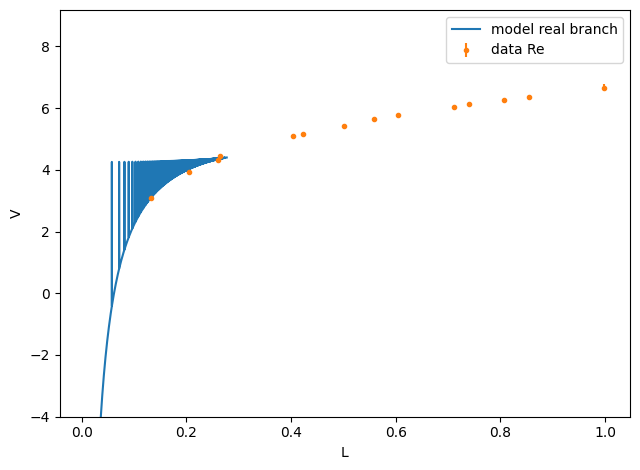

In [9]:
with torch.no_grad():
    Lm_final, Vm_final = connected_branch(model)
    V_branch = Vm_final + model.shift

plt.figure(figsize=(6.5,4.8))
plt.plot(Lm_final.cpu(), V_branch.cpu(), '-', label='model real branch')
plt.errorbar(L_all.cpu(), V_all.real.cpu(),
             yerr=sigma_all.real.cpu(),
             fmt='.', label='data Re')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.ylim(-4, None); plt.tight_layout()


(-4.0, 9.17666705913585)

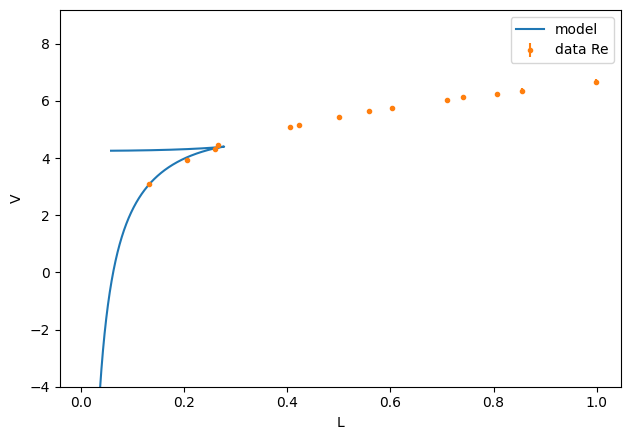

In [10]:
with torch.no_grad():
    zs_plot = torch.linspace(0.02, 0.9995, 4000, dtype=dt, device=dev)
    Lc = model.integrate_L(zs_plot).real
    Vc = model.integrate_V(zs_plot).real + model.shift  # single-valued V(z*)

L_np = Lc.cpu().numpy()
V_np = Vc.cpu().numpy()

plt.figure(figsize=(6.5,4.5))
plt.plot(L_np, V_np, '-', label='model')        # this includes the swallowtail loop
plt.errorbar(L_all.cpu(), V_all.real.cpu(),
             yerr=sigma_all.real.cpu(), fmt='.', label='data Re')
plt.xlabel('L'); plt.ylabel('V'); plt.legend(); plt.tight_layout()
plt.ylim(-4,None)


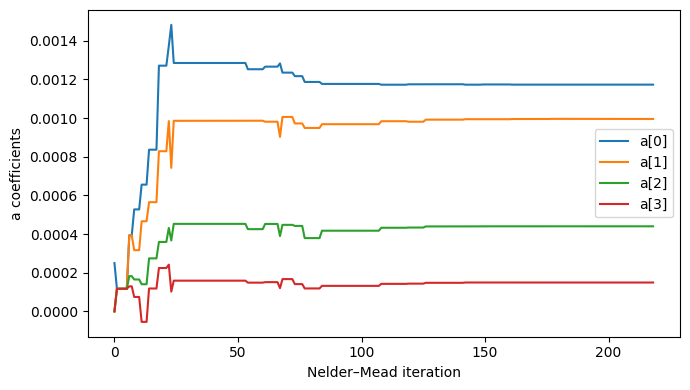

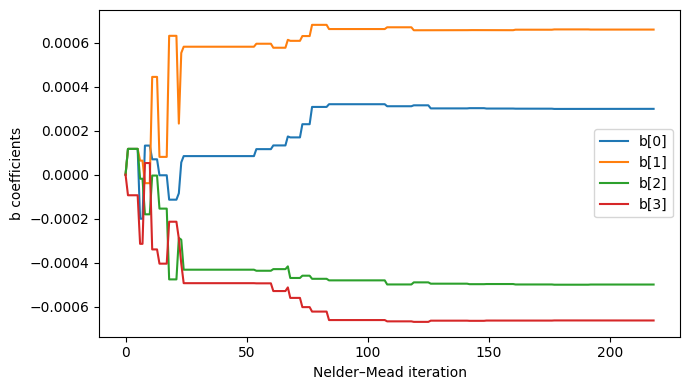

In [11]:
a_hist_np = np.array(a_history)  # shape (n_iter, N)
b_hist_np = np.array(b_history)

plt.figure(figsize=(7,4))
for i in range(a_hist_np.shape[1]):
    plt.plot(a_hist_np[:, i], label=f'a[{i}]')
plt.xlabel('Nelder–Mead iteration')
plt.ylabel('a coefficients')
plt.legend()
plt.tight_layout()

plt.figure(figsize=(7,4))
for i in range(b_hist_np.shape[1]):
    plt.plot(b_hist_np[:, i], label=f'b[{i}]')
plt.xlabel('Nelder–Mead iteration')
plt.ylabel('b coefficients')
plt.legend()
plt.tight_layout()


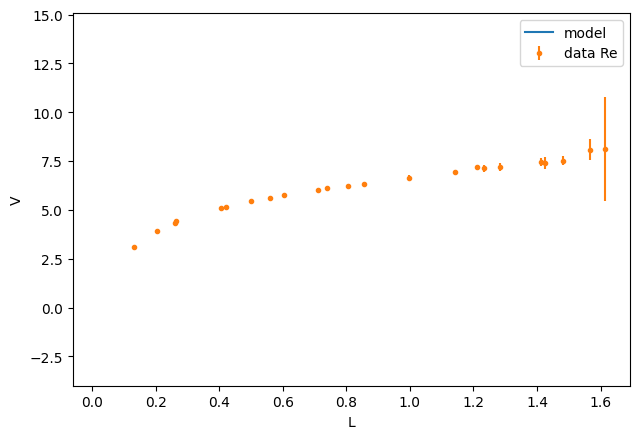

In [12]:
with torch.no_grad():
    zs = torch.linspace(0.05, 0.99, 800, device=dev)
    Lc = model.integrate_L(zs).real
    Vc = model.integrate_V(zs).real + model.shift

plt.figure(figsize=(6.5,4.5))
plt.plot(Lc.cpu(), Vc.cpu(), label="model")
plt.errorbar(dataset.L.cpu(), dataset.V.real.cpu(),
             yerr=dataset.sigma.real.cpu(), fmt='.', label='data Re')
plt.ylim(-4, None)
plt.xlabel("L"); plt.ylabel("V"); plt.legend(); plt.tight_layout()
